<a href="https://colab.research.google.com/github/shumphries22/Verbal-and-Non-Verbal-Response-Based-on-Facial-Emotion-Recognition-and-Emotional-Voice-Recognition/blob/main/facialexpression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#FACIAL EXPRESSION MODEL

In [ ]:
!pip install utils
!pip install livelossplot
!pip install tensorflow


  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=cd508c52f3b58a81edb17314572c5541e3651fc641ac1189680d2a8ce306667e
  Stored in directory: /root/.cache/pip/wheels/15/0c/b3/674aea8c5d91c642c817d4d630bd58faa316724b136844094d
Successfully built utils


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
from livelossplot.inputs.tf_keras import PlotLossesCallback
import tensorflow as tf

from google.colab import files
uploadedfiles = files.upload()

trainingDataLocation = '/content/FacialExpressionDetection.zip'

Saving FacialExpressionDetection.zip to FacialExpressionDetection.zip


In [ ]:
import zipfile
with zipfile.ZipFile(trainingDataLocation, 'r') as zip_ref:
    zip_ref.extractall('/content/FacialExpressionDetection')

dataLocation = '/content/FacialExpressionDetection'
trainingDataLocation = dataLocation + '/train/train'
validationDataLocation = dataLocation + '/test/test'

In [ ]:
#Setup for neural networks model

imgSize = 48
batchSize =64

trainDataGen = ImageDataGenerator(horizontal_flip= True)
trainGen = trainDataGen.flow_from_directory(trainingDataLocation,
                                            target_size=(imgSize, imgSize),
                                            color_mode="grayscale",
                                            batch_size=batchSize,
                                            class_mode='categorical',
                                            shuffle=True)


testDataGen = ImageDataGenerator(horizontal_flip= True)
testGen = testDataGen.flow_from_directory(trainingDataLocation,
                                            target_size=(imgSize, imgSize),
                                            color_mode="grayscale",
                                            batch_size=batchSize,
                                            class_mode='categorical',
                                            shuffle=False)


Found 28709 images belonging to 7 classes.
Found 28709 images belonging to 7 classes.


In [ ]:
#Initialise CNN
nNModel = Sequential()

#First Convolutional Layer
nNModel.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', input_shape=(48,48,1)))
#Normalise activations to stabilise training and improve convergence :)
nNModel.add(BatchNormalization())
#Reduce the dimensions by half!
nNModel.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
#Drop a percentage of random neurons to prevent overfitting
nNModel.add(Dropout(0.25))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Second Convolutional Layer (128 filters instead of 64)
nNModel.add(Conv2D(128, kernel_size=(5,5), padding='same', activation='relu'))
nNModel.add(BatchNormalization())
nNModel.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
nNModel.add(Dropout(0.25))

In [ ]:
#Third Convolutional Layer (512 filters instead of 128)
nNModel.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
nNModel.add(BatchNormalization())
nNModel.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
nNModel.add(Dropout(0.25))

In [ ]:
#Fourth Convolutional Layer (same as third)
nNModel.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
nNModel.add(BatchNormalization())
nNModel.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
nNModel.add(Dropout(0.25))

In [ ]:
#Flatten multidimensional into 1D
nNModel.add(Flatten())

In [ ]:
#Connected Layers
#First
nNModel.add(Dense(256))
nNModel.add(BatchNormalization())
nNModel.add(Activation('relu'))
nNModel.add(Dropout(0.25))

#Second
nNModel.add(Dense(512))
nNModel.add(BatchNormalization())
nNModel.add(Activation('relu'))
nNModel.add(Dropout(0.25))

In [ ]:
#Ouput Layer
nNModel.add(Dense(7, activation='softmax'))

In [ ]:
#Compile

optimiser = Adam(learning_rate=0.001)
nNModel.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['accuracy'])

nNModel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,478,727 (17.08 MB)

 Trainable params: 4,474,759 (17.07 MB)

 Non-trainable params: 3,968 (15.50 KB)

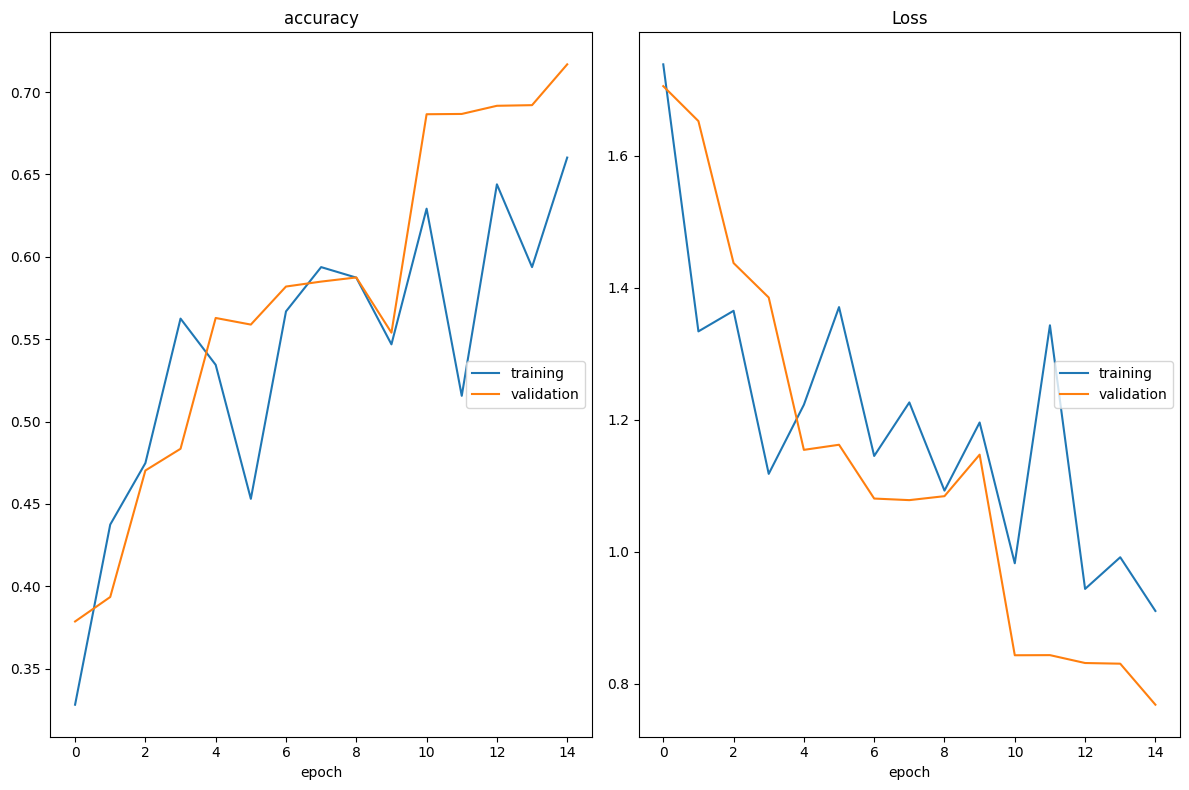

accuracy
	training         	 (min:    0.328, max:    0.660, cur:    0.660)
	validation       	 (min:    0.379, max:    0.717, cur:    0.717)
Loss
	training         	 (min:    0.911, max:    1.739, cur:    0.911)
	validation       	 (min:    0.768, max:    1.706, cur:    0.768)

Epoch 15: saving model to nNModel.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 1829s 4s/step - accuracy: 0.6602 - loss: 0.9104 - val_accuracy: 0.7168 - val_loss: 0.7685 - learning_rate: 1.0000e-04


In [ ]:
#amount of runs of model
epochs = 15
stepsEpochs = trainGen.n//trainGen.batch_size
testSteps = testGen.n//testGen.batch_size

reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=0.1,
                             patience=2,
                             min_lr=0.00001,
                             mode='auto')

checkpoint = ModelCheckpoint('nNModel.weights.h5',
                             monitor='val_accuracy',
                             save_weights_only=True,
                             mode='max',
                             verbose=1)

callback = [PlotLossesCallback(), checkpoint, reduceLR]
history = nNModel.fit(x=trainGen,
                      steps_per_epoch=stepsEpochs,
                      epochs=epochs,
                      validation_data=testGen,
                      validation_steps=testSteps,
                      callbacks=callback)

jSONNeuralModel = nNModel.to_json()
nNModel.save_weights('nNModel.weights.h5')
with open("nNModel.json", "w") as jsonFile:
    jsonFile.write(jSONNeuralModel)

#WORKING WITH THE MODEL

In [22]:
from keras.models import model_from_json

# 1. Load the model architecture
with open("nNModel.json", "r") as json_file:
    loaded_model_json = json_file.read()

model = model_from_json(loaded_model_json)

# 2. Load the weights
model.load_weights("nNModel.weights.h5")

In [29]:
from tensorflow.keras.models import model_from_json
import numpy as np
import cv2

class FacialExpressionType(object):
  emotions = ["Angry", "Disgust", "Fear", "Happy",
              "Neutral", "Sad", "Surprise"]
  def __init__ (self, model_json_file, model_weights_file):
    with open(model_json_file, "r") as json_file:
      loaded_model_json = json_file.read()
      self.loaded_model = model_from_json(loaded_model_json)
    self.loaded_model.load_weights(model_weights_file)
    self.loaded_model.make_predict_function()
    #self.loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  def emotionPrediction(self, img):
    self.pred = self.loaded_model.predict(img)
    return FacialExpressionType.emotions[np.argmax(self.pred)]

#from google.colab import files
#uploadedfiles = files.upload()

model = FacialExpressionType("nNModel.json", "nNModel.weights.h5")

#camera class
face = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
font = cv2.FONT_HERSHEY_SIMPLEX

class camera(object):
  def __init__(self):
    self.video = cv2.VideoCapture(0)
    if not self.video.isOpened():
        raise Exception("Could not open webcam")

  def __del__(self):
    self.video.release()

  def frameBoundaries(self):
    success, frame = self.video.read()
    if not success:
        return None
    labels = []
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face.detectMultiScale(gray, 1.3, 5)

    for(x, y, w, h) in faces:
      fc = gray[y:y+h, x:x+w]
      roi = cv2.resize(fc, (48,48))
      pred = model.emotionPrediction(roi[np.newaxis, :, :, np.newaxis])
      cv2.putText(frame, pred, (x, y), font, 1, (255,255,0), 2)
      cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255,0), 2)
    return frame

def generate(camera0):
  while True:
    frame = camera0.frameBoundaries()
    cv2.imshow('Facial Expression Recognition', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
      break
  cv2.destroyAllWindows()


generate(camera())


Exception: Could not open webcam